In [1]:
# Dependencies and Setup
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from databaseconfig import user, pwd, host, db

In [2]:
# Create an engine that can talk to the database
engine = create_engine(f'postgres://{user}:{pwd}@{host}/{db}')
connection = engine.connect()

In [3]:
# Select the table Titles in the database
titles_data = pd.read_sql("SELECT * FROM titles", connection)
titles_data.head()

,emp_no,title,from_date,to_date
0,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,Staff,1996-08-03,9999-01-01
2,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,Engineer,1986-12-01,1995-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01


In [4]:
# Select the table Salaries in the database
salaries_data = pd.read_sql("SELECT * FROM salaries", connection)
salaries_data.head()

,emp_no,salary,from_date,to_date
0,10001,"$60,117.00",1986-06-26,1987-06-26
1,10002,"$65,828.00",1996-08-03,1997-08-03
2,10003,"$40,006.00",1995-12-03,1996-12-02
3,10004,"$40,054.00",1986-12-01,1987-12-01
4,10005,"$78,228.00",1989-09-12,1990-09-12


In [5]:
titles_data.count()

emp_no       443308
title        443308
from_date    443308
to_date      443308
dtype: int64

In [6]:
salaries_data.count()

emp_no       300024
salary       300024
from_date    300024
to_date      300024
dtype: int64

In [7]:
# Merge the two databases and check the values types
db = pd.merge(titles_data, salaries_data, on="emp_no", how='right')
db.head()

,emp_no,title,from_date_x,to_date_x,salary,from_date_y,to_date_y
0,10001,Senior Engineer,1986-06-26,9999-01-01,"$60,117.00",1986-06-26,1987-06-26
1,10002,Staff,1996-08-03,9999-01-01,"$65,828.00",1996-08-03,1997-08-03
2,10003,Senior Engineer,1995-12-03,9999-01-01,"$40,006.00",1995-12-03,1996-12-02
3,10004,Engineer,1986-12-01,1995-12-01,"$40,054.00",1986-12-01,1987-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01,"$40,054.00",1986-12-01,1987-12-01


In [8]:
# Remove rows with salary period no corresponding at title period
db = db[db['from_date_x'] == (db['from_date_y'])] 

In [9]:
# Rename Columns
db = db.rename(columns={"title":"Title", "salary":"Salary"})

In [10]:
# Remove the currency sign in order to convert the serie in float
db["Salary"] = db["Salary"].replace('[\$,]', '', regex=True).astype(float)

In [11]:
# Group values by titles
groupby_title = db.groupby(["Title"])["Salary"].mean()
groupby_title

Title
Assistant Engineer    48493.204786
Engineer              48547.807738
Manager               57290.777778
Senior Engineer       48425.342063
Senior Staff          58547.693682
Staff                 58465.500955
Technique Leader      48580.975053
Name: Salary, dtype: float64

In [12]:
# Build the DataFrame, sort values by salary, and round the values
df = pd.DataFrame(groupby_title).reset_index()
final_df = df.sort_values(by=['Salary'], ascending=False)
final_df['Salary'] = final_df['Salary'].round(0)
final_df

,Title,Salary
4,Senior Staff,58548.0
5,Staff,58466.0
2,Manager,57291.0
6,Technique Leader,48581.0
1,Engineer,48548.0
0,Assistant Engineer,48493.0
3,Senior Engineer,48425.0


In [13]:
# Define values in order to generate the plot
salaries = final_df['Salary']
titles = final_df['Title']

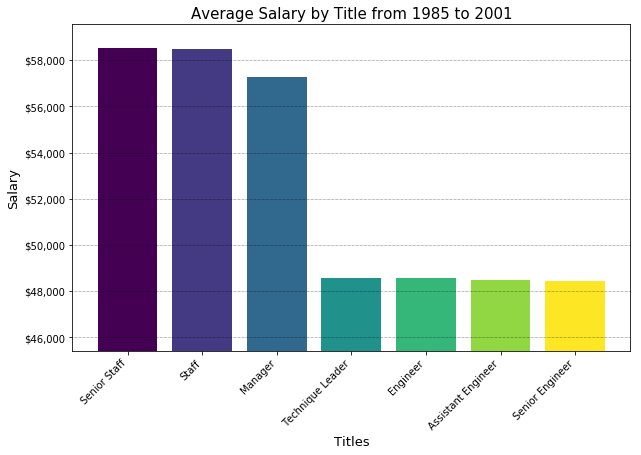

In [14]:
# Generate the Plot
fig, ax = plt.subplots(figsize = (10,6))
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(titles)))
ax.bar(titles, salaries, color=colors , alpha=1, align="center")

# Set the major ticks
ticks = np.arange(len(titles))
ax.set_xticklabels(titles, rotation = 45, ha='right')

# Create title and labels
ax.set_title("Average Salary by Title from 1985 to 2001", fontsize=15)
ax.set_ylabel("Salary", fontsize=13)
ax.set_xlabel("Titles", fontsize=13)

# Set the currency sign on the y axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

# Turn on the grid
ax.yaxis.grid(which='major', color='black', linestyle='dotted', linewidth=0.5)

# Set x axe limits
ax.set_ylim(min(salaries)-3000, max(salaries)+1000)

# Save and display the chart
plt.savefig("Images/average_salary_by_title.png")
plt.show()